In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

data_root = "./data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_set = datasets.CIFAR10(
    root = data_root,
    train = True,
    download = True,
    transform = transform
)

test_set = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform
)

In [2]:
from torch.utils.data import DataLoader

batch_size = 100

train_loader = DataLoader(
    train_set, 
    batch_size = batch_size,
    shuffle = True
)

test_loader = DataLoader(
    test_set,  
    batch_size = batch_size,
    shuffle = False
)

In [3]:
import torch
import torch.nn as nn

class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [4]:
from tqdm.notebook import tqdm

def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        n_train_acc, n_val_acc = 0, 0
        train_loss, val_loss = 0, 0
        n_train, n_test = 0, 0

        net.train()

        for inputs, labels in tqdm(train_loader):
            train_batch_size = len(labels)
            n_train += train_batch_size

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            predicted = torch.max(outputs, 1)[1]

            train_loss += loss.item() * train_batch_size
            n_train_acc += (predicted == labels).sum().item()

        net.eval()

        for inputs_test, labels_test in test_loader:
            test_batch_size = len(labels_test)
            n_test += test_batch_size

            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            outputs_test = net(inputs_test)

            loss_test = criterion(outputs_test, labels_test)

            predicted_test = torch.max(outputs_test, 1)[1]

            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test

        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')

        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))

    return history

def torch_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_output = len(list(set(classes)))
torch_seed(36) # c24036
lr = 0.001

net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0, 5))

num_epochs = 50
history1 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.55109 acc: 0.42732 val_loss: 1.22511, val_acc: 0.54690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.08700 acc: 0.60914 val_loss: 0.95828, val_acc: 0.65630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.86292 acc: 0.69316 val_loss: 0.84928, val_acc: 0.70200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.71340 acc: 0.74790 val_loss: 0.74005, val_acc: 0.74140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.60434 acc: 0.78766 val_loss: 0.78105, val_acc: 0.73530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.52367 acc: 0.81560 val_loss: 0.70993, val_acc: 0.76400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.44310 acc: 0.84430 val_loss: 0.69547, val_acc: 0.78080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.36801 acc: 0.86926 val_loss: 0.74538, val_acc: 0.77230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.31046 acc: 0.88954 val_loss: 0.74576, val_acc: 0.78060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.25801 acc: 0.90738 val_loss: 0.77330, val_acc: 0.77660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.20525 acc: 0.92678 val_loss: 0.85152, val_acc: 0.78330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.17269 acc: 0.93926 val_loss: 0.89829, val_acc: 0.78010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.13981 acc: 0.94960 val_loss: 1.09209, val_acc: 0.77010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.14044 acc: 0.94964 val_loss: 1.03610, val_acc: 0.77310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.11407 acc: 0.95966 val_loss: 1.13536, val_acc: 0.76950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.10816 acc: 0.96184 val_loss: 1.15126, val_acc: 0.77600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.10179 acc: 0.96336 val_loss: 1.23796, val_acc: 0.76770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.09009 acc: 0.96896 val_loss: 1.29449, val_acc: 0.76780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.09073 acc: 0.96900 val_loss: 1.27582, val_acc: 0.77370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.08255 acc: 0.97230 val_loss: 1.36855, val_acc: 0.76610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.08296 acc: 0.97096 val_loss: 1.33939, val_acc: 0.77080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.08200 acc: 0.97102 val_loss: 1.44931, val_acc: 0.76880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.08321 acc: 0.97156 val_loss: 1.34469, val_acc: 0.77210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.06987 acc: 0.97628 val_loss: 1.43826, val_acc: 0.77320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.07278 acc: 0.97540 val_loss: 1.57694, val_acc: 0.77380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.06901 acc: 0.97674 val_loss: 1.48392, val_acc: 0.77230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.06207 acc: 0.97962 val_loss: 1.64748, val_acc: 0.76270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.06831 acc: 0.97714 val_loss: 1.51764, val_acc: 0.76500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.06571 acc: 0.97746 val_loss: 1.57200, val_acc: 0.77190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.07127 acc: 0.97644 val_loss: 1.55688, val_acc: 0.77140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.06312 acc: 0.97930 val_loss: 1.61358, val_acc: 0.76720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.06572 acc: 0.97790 val_loss: 1.65252, val_acc: 0.76680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.06117 acc: 0.97984 val_loss: 1.57890, val_acc: 0.76940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.06069 acc: 0.98012 val_loss: 1.57324, val_acc: 0.77620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.05859 acc: 0.97988 val_loss: 1.62503, val_acc: 0.76850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.06287 acc: 0.97942 val_loss: 1.59273, val_acc: 0.76690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.06436 acc: 0.97848 val_loss: 1.66060, val_acc: 0.77460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.05370 acc: 0.98206 val_loss: 1.89917, val_acc: 0.76220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.05928 acc: 0.98040 val_loss: 1.84152, val_acc: 0.77140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.05659 acc: 0.98128 val_loss: 1.72415, val_acc: 0.76980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.05086 acc: 0.98358 val_loss: 1.75074, val_acc: 0.77900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.05667 acc: 0.98224 val_loss: 1.60103, val_acc: 0.77200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.05656 acc: 0.98206 val_loss: 1.76697, val_acc: 0.77010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.04562 acc: 0.98540 val_loss: 1.87198, val_acc: 0.76400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.05426 acc: 0.98342 val_loss: 1.93040, val_acc: 0.76200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.06034 acc: 0.98086 val_loss: 1.72455, val_acc: 0.77400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.06323 acc: 0.97980 val_loss: 1.68481, val_acc: 0.76940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.05108 acc: 0.98380 val_loss: 1.73137, val_acc: 0.76870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.04706 acc: 0.98528 val_loss: 1.91654, val_acc: 0.77430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.05562 acc: 0.98216 val_loss: 1.86006, val_acc: 0.77150


In [6]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_output = len(list(set(classes)))
torch_seed(36) # c24036
lr = 0.001

net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0, 5))

num_epochs = 50
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.69611 acc: 0.36914 val_loss: 1.34415, val_acc: 0.50740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.30414 acc: 0.52562 val_loss: 1.12972, val_acc: 0.59660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.10821 acc: 0.60344 val_loss: 0.91711, val_acc: 0.67040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.97504 acc: 0.65656 val_loss: 0.86001, val_acc: 0.69880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.89131 acc: 0.68898 val_loss: 0.77833, val_acc: 0.72950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.82468 acc: 0.71328 val_loss: 0.70545, val_acc: 0.75150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.76975 acc: 0.73524 val_loss: 0.70421, val_acc: 0.75500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.73108 acc: 0.74860 val_loss: 0.67191, val_acc: 0.77140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.69705 acc: 0.76062 val_loss: 0.63925, val_acc: 0.77580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.67250 acc: 0.76942 val_loss: 0.61278, val_acc: 0.78920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.64351 acc: 0.77736 val_loss: 0.62790, val_acc: 0.78800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.62698 acc: 0.78510 val_loss: 0.58995, val_acc: 0.80190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.61294 acc: 0.79006 val_loss: 0.61618, val_acc: 0.79440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.59091 acc: 0.79572 val_loss: 0.61492, val_acc: 0.79690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.57960 acc: 0.80034 val_loss: 0.58971, val_acc: 0.79880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.56298 acc: 0.80578 val_loss: 0.57786, val_acc: 0.80680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.55169 acc: 0.80874 val_loss: 0.55699, val_acc: 0.80900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.53702 acc: 0.81576 val_loss: 0.57492, val_acc: 0.80880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.52346 acc: 0.81890 val_loss: 0.56001, val_acc: 0.81590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51707 acc: 0.82054 val_loss: 0.55272, val_acc: 0.81740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51185 acc: 0.82344 val_loss: 0.57176, val_acc: 0.80980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50443 acc: 0.82446 val_loss: 0.56110, val_acc: 0.81790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50246 acc: 0.82700 val_loss: 0.55312, val_acc: 0.81780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49055 acc: 0.83108 val_loss: 0.55766, val_acc: 0.82060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.47799 acc: 0.83532 val_loss: 0.55193, val_acc: 0.81960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.47873 acc: 0.83670 val_loss: 0.55239, val_acc: 0.81820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.46793 acc: 0.83848 val_loss: 0.55054, val_acc: 0.82410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.45960 acc: 0.84128 val_loss: 0.58880, val_acc: 0.81230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.46306 acc: 0.84174 val_loss: 0.54880, val_acc: 0.82180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.45360 acc: 0.84424 val_loss: 0.53761, val_acc: 0.82650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.45349 acc: 0.84320 val_loss: 0.54529, val_acc: 0.82220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.44758 acc: 0.84540 val_loss: 0.54235, val_acc: 0.82330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.43517 acc: 0.85016 val_loss: 0.52933, val_acc: 0.82870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.43366 acc: 0.84980 val_loss: 0.54359, val_acc: 0.82520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.43025 acc: 0.85184 val_loss: 0.55417, val_acc: 0.82780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.43206 acc: 0.85272 val_loss: 0.53903, val_acc: 0.82410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.42589 acc: 0.85336 val_loss: 0.54932, val_acc: 0.82480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.42296 acc: 0.85450 val_loss: 0.53700, val_acc: 0.82980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.41982 acc: 0.85508 val_loss: 0.53035, val_acc: 0.82920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.40983 acc: 0.85852 val_loss: 0.53197, val_acc: 0.82890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.40600 acc: 0.86198 val_loss: 0.54357, val_acc: 0.82800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.41017 acc: 0.85790 val_loss: 0.51761, val_acc: 0.83410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.40859 acc: 0.85708 val_loss: 0.56599, val_acc: 0.82430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.40935 acc: 0.85864 val_loss: 0.54077, val_acc: 0.82650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.39850 acc: 0.86256 val_loss: 0.51534, val_acc: 0.83520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.39784 acc: 0.86154 val_loss: 0.53672, val_acc: 0.83570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.39490 acc: 0.86326 val_loss: 0.53958, val_acc: 0.83320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.39346 acc: 0.86162 val_loss: 0.52447, val_acc: 0.83770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.39599 acc: 0.86290 val_loss: 0.52425, val_acc: 0.83810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.38513 acc: 0.86788 val_loss: 0.52114, val_acc: 0.83670


In [8]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_output = len(list(set(classes)))
torch_seed(36) # c24036
lr = 0.001

net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0, 5))

num_epochs = 50
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.50424 acc: 0.44436 val_loss: 1.17668, val_acc: 0.58730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.14195 acc: 0.59632 val_loss: 0.94579, val_acc: 0.66390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.98975 acc: 0.65280 val_loss: 0.83308, val_acc: 0.70790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.89341 acc: 0.68964 val_loss: 0.76825, val_acc: 0.73770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.82147 acc: 0.71750 val_loss: 0.71093, val_acc: 0.74760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.76496 acc: 0.73740 val_loss: 0.65721, val_acc: 0.77200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.72588 acc: 0.75442 val_loss: 0.63950, val_acc: 0.78010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.68978 acc: 0.76440 val_loss: 0.62071, val_acc: 0.78730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.65805 acc: 0.77702 val_loss: 0.57131, val_acc: 0.80570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.63296 acc: 0.78656 val_loss: 0.53975, val_acc: 0.81740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.59930 acc: 0.79796 val_loss: 0.53080, val_acc: 0.81980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.57206 acc: 0.80810 val_loss: 0.52225, val_acc: 0.82530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54958 acc: 0.81574 val_loss: 0.54642, val_acc: 0.81840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53026 acc: 0.81918 val_loss: 0.56102, val_acc: 0.81350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.51846 acc: 0.82462 val_loss: 0.50014, val_acc: 0.83410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.49762 acc: 0.83282 val_loss: 0.55550, val_acc: 0.82020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.48273 acc: 0.83908 val_loss: 0.48917, val_acc: 0.83760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.46319 acc: 0.84520 val_loss: 0.49669, val_acc: 0.83710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.44805 acc: 0.84948 val_loss: 0.46705, val_acc: 0.84570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.43713 acc: 0.85334 val_loss: 0.48001, val_acc: 0.84020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.42781 acc: 0.85596 val_loss: 0.46717, val_acc: 0.84590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.41364 acc: 0.85914 val_loss: 0.47359, val_acc: 0.84950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.40856 acc: 0.86282 val_loss: 0.44881, val_acc: 0.85660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.39195 acc: 0.86746 val_loss: 0.46970, val_acc: 0.85060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.38676 acc: 0.87058 val_loss: 0.46599, val_acc: 0.85280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.37569 acc: 0.87348 val_loss: 0.45993, val_acc: 0.85540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.36317 acc: 0.87742 val_loss: 0.46018, val_acc: 0.85580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.36214 acc: 0.87714 val_loss: 0.46671, val_acc: 0.85370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.35209 acc: 0.88060 val_loss: 0.44416, val_acc: 0.86210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.34480 acc: 0.88260 val_loss: 0.46086, val_acc: 0.85400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.33488 acc: 0.88692 val_loss: 0.45211, val_acc: 0.85920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.33140 acc: 0.88802 val_loss: 0.42550, val_acc: 0.86320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.31995 acc: 0.89206 val_loss: 0.44071, val_acc: 0.86530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.31421 acc: 0.89202 val_loss: 0.43327, val_acc: 0.86330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.31502 acc: 0.89316 val_loss: 0.43894, val_acc: 0.86340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.30847 acc: 0.89530 val_loss: 0.46382, val_acc: 0.85790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.30002 acc: 0.89846 val_loss: 0.45687, val_acc: 0.85860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.29353 acc: 0.90000 val_loss: 0.44135, val_acc: 0.86520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.28862 acc: 0.90274 val_loss: 0.47195, val_acc: 0.85960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.28416 acc: 0.90382 val_loss: 0.42734, val_acc: 0.86900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.28384 acc: 0.90142 val_loss: 0.44081, val_acc: 0.86700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.28279 acc: 0.90356 val_loss: 0.45314, val_acc: 0.86110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.27077 acc: 0.90744 val_loss: 0.46713, val_acc: 0.85890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.27074 acc: 0.90860 val_loss: 0.46275, val_acc: 0.86410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.26432 acc: 0.90934 val_loss: 0.43476, val_acc: 0.87120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.26253 acc: 0.90970 val_loss: 0.44517, val_acc: 0.86870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.25632 acc: 0.91164 val_loss: 0.43729, val_acc: 0.86910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.25996 acc: 0.91090 val_loss: 0.45003, val_acc: 0.87140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.24870 acc: 0.91416 val_loss: 0.44968, val_acc: 0.86710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.24618 acc: 0.91436 val_loss: 0.44777, val_acc: 0.86590


CNN2の状態
初期状態: 損失: 1.22511 精度: 0.54690
最終状態: 損失: 1.86006 精度: 0.77150
CNN3の状態
初期状態: 損失: 1.34415 精度: 0.50740
最終状態: 損失: 0.52114 精度: 0.83670
CNN4の状態
初期状態: 損失: 1.17668 精度: 0.58730
最終状態: 損失: 0.44777 精度: 0.86590


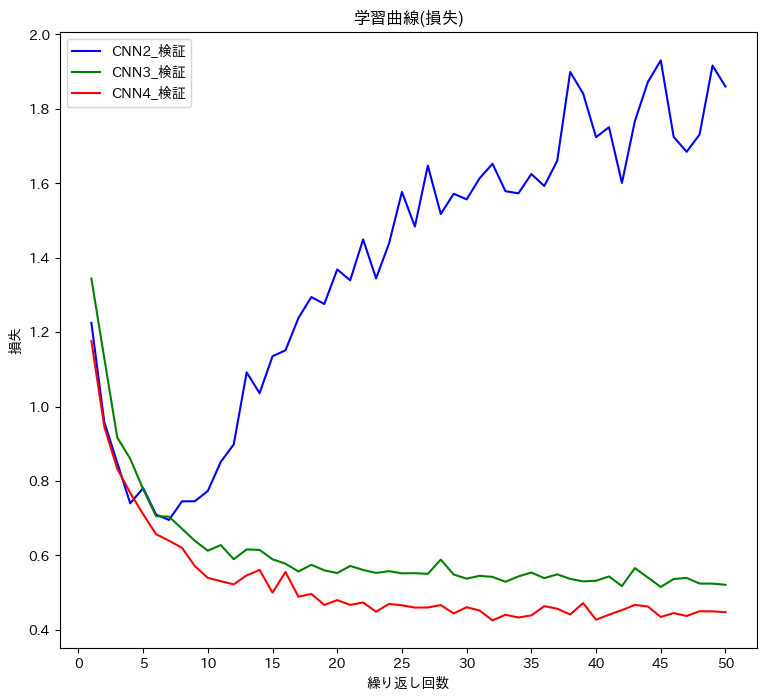

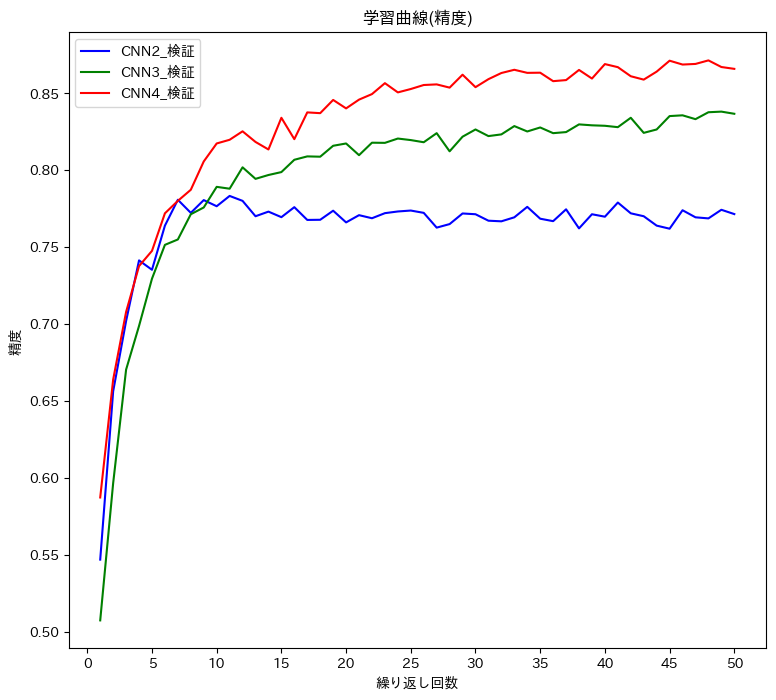

In [10]:
import matplotlib.pyplot as plt
import japanize_matplotlib

print("CNN2の状態")
print(f'初期状態: 損失: {history1[0,3]:.5f} 精度: {history1[0,4]:.5f}')
print(f'最終状態: 損失: {history1[-1,3]:.5f} 精度: {history1[-1,4]:.5f}' )

print("CNN3の状態")
print(f'初期状態: 損失: {history2[0,3]:.5f} 精度: {history2[0,4]:.5f}')
print(f'最終状態: 損失: {history2[-1,3]:.5f} 精度: {history2[-1,4]:.5f}' )

print("CNN4の状態")
print(f'初期状態: 損失: {history3[0,3]:.5f} 精度: {history3[0,4]:.5f}')
print(f'最終状態: 損失: {history3[-1,3]:.5f} 精度: {history3[-1,4]:.5f}' )

plt.figure(figsize=(9,8))
num_epochs1 = len(history1)
unit1 = num_epochs1 / 10
num_epochs2 = len(history2)
unit2 = num_epochs2 / 10
num_epochs3 = len(history3)
unit3 = num_epochs3 / 10
plt.plot(history1[:,0], history1[:,3], 'b', label='CNN2_検証')
plt.xticks(np.arange(0,num_epochs1+1, unit1))
plt.plot(history2[:,0], history2[:,3], 'g', label='CNN3_検証')
plt.xticks(np.arange(0,num_epochs2+1, unit2))
plt.plot(history3[:,0], history3[:,3], 'r', label='CNN4_検証')
plt.xticks(np.arange(0,num_epochs3+1, unit3))
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

plt.figure(figsize=(9,8))
plt.plot(history1[:,0], history1[:,4], 'b', label='CNN2_検証')
plt.xticks(np.arange(0,num_epochs1+1, unit1))
plt.plot(history2[:,0], history2[:,4], 'g', label='CNN3_検証')
plt.xticks(np.arange(0,num_epochs2+1, unit2))
plt.plot(history3[:,0], history3[:,4], 'r', label='CNN4_検証')
plt.xticks(np.arange(0,num_epochs3+1, unit3))
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()